#### Import calls

In [1]:
import distutils.util
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output, Audio
clear_output()

# import from other python files
from pend_utils import pd_control
# from cane_builder import CaneEditor

from simple_pid import PID



BROWN = np.array([0.4, 0.24, 0.0, 1])

#### Let's build the tree!

In [2]:
branch_model = """
<mujoco model="single_pendulum">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0" stiffness="295" springref="0" damping="0.15"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1" solref="0.1 1" solimp=".95 1 0.0025" friction="0 0 0"/> 
    </body>

  </worldbody>

  <keyframe>
    <key name="initial" qpos="0" qvel="0" />
  </keyframe>
</mujoco>
"""

Let's show the initial MJDF:

""

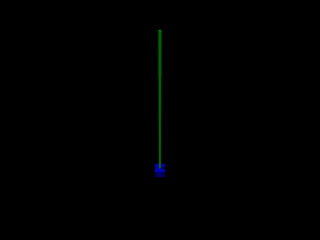

In [3]:
init_model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(init_model)
with mujoco.Renderer(init_model) as renderer:
    mujoco.mj_forward(init_model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

Here's the class we'll use to edit the MJDF. Right now all it does is turn the little box red:

In [4]:
class CaneEditor():
    def __init__(self, xml_name):
        self.spec = mujoco.MjSpec.from_string(xml_name)
        self.model = self.spec.compile()

        self.spec.modelname = "edited model"
        geoms = self.spec.worldbody.find_all(mujoco.mjtObj.mjOBJ_GEOM)
        geoms[0].rgba = [1, 0, 0, 1]

    # def add_segment(self):
        

    def show_new_model(self):
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(init_model, data)
            renderer.update_scene(data)
            media.show_image(renderer.render())

In [5]:
# editor = CaneEditor(branch_model)
# editor.show_new_model()

In [46]:
model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(model)

model.opt.timestep = .00005

STEPPING = False

DURATION = 45
framerate = 60
CTRL_POS = 0.001 # 1 mm
CTRL_POS_UPDATE_RATE = 1 # s
CTRL_SPD = 0.001 # 1 mm/s

init_angles = np.zeros(model.njnt)
timevals = []
posvals = []
velvals = []
forcevals = []

KU=375
TU=0.103
pid = PID(Kp=KU*.45, Ki=200, Kd=1*KU*TU, setpoint=0.0, output_limits=(-100, 1000))

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model) as renderer:
  time_since_last_ctrl_update = 0.0

  while data.time < DURATION:

    # Figure out the current setpoint
    if STEPPING:
      if time_since_last_ctrl_update >= CTRL_POS_UPDATE_RATE:
        time_since_last_ctrl_update = 0.0
        CTRL_POS += 0.001
        pid.setpoint = CTRL_POS
        print(f"Time is now {data.time:.3f} s, setting control position to {CTRL_POS:.3f} m")
    else:
      ctrl_angle = CTRL_SPD * data.time
      pid.setpoint = ctrl_angle

    # figure out what the control force should be
    current_angle = data.qpos[0]
    force_mag= 295*data.qpos[0]+pid(current_angle)

    # apply the control force on the branch
    branch_body_id = model.body('branch_link').id
    force_vec = np.array([force_mag, 0, 0])  # Force in the world x-direction
    # Apply a constant force in the world x-direction at a point 0.75m above the branch pivot
    # Get the world position of the pivot (branch base)
    pivot_pos = data.xpos[branch_body_id].copy()  # World position of branch_link origin
    # The pivot is at the origin of branch_link, so the application point is 0.75m above in z
    application_point_world = pivot_pos + np.array([0.0, 0.0, 0.75])
    # Center of mass of the branch in world frame
    branch_com_world = data.xpos[branch_body_id].copy()   

    # Calculate the force and torque to apply
    # Force is applied at the application point, so we need to calculate the torque
    r = application_point_world - branch_com_world  # Vector from COM to application point
    # Torque is the cross product of r and force
    applied_torque = np.cross(r, force_vec) 

    # Apply force and torque at every step (inside the sim loop)
    data.xfrc_applied[branch_body_id, :3] = force_vec
    data.xfrc_applied[branch_body_id, 3:] = applied_torque

    # step the simulation 

    # update the values 
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    velvals.append(data.qvel.copy())
    forcevals.append(force_mag.copy())

    # --------------------------------------------------------------
    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)
    time_since_last_ctrl_update += model.opt.timestep

media.show_video(frames, fps=framerate)
  

Text(0.5, 0, 'Time (seconds)')

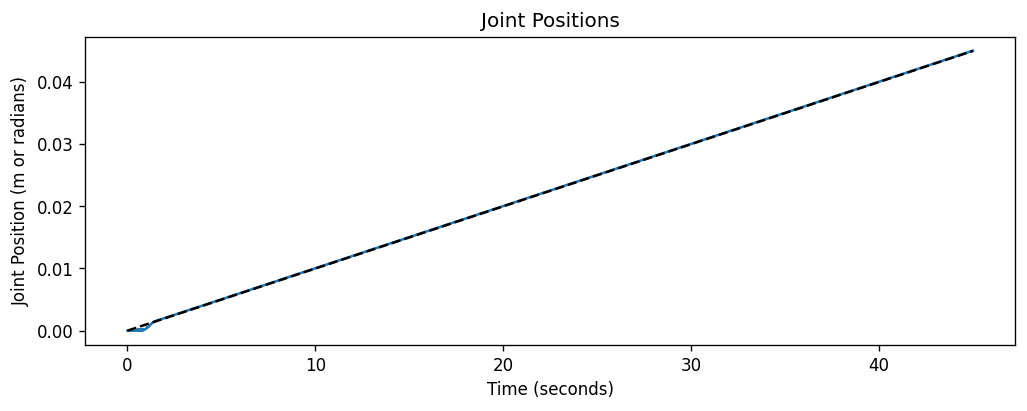

In [47]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

pos_array = np.array(posvals)  # shape: (timesteps, njnt)
  # shape: (timesteps, njnt)
for j in range(model.njnt):
    # Get joint name using the MuJoCo API
    joint_name = model.joint(j).name
    ax.plot(timevals, pos_array[:, j], label=joint_name)

if STEPPING:
    # Add a reference line that steps up by 0.001 every 1 second
  step_height = 0.001
  step_interval = 1.0
  step_times = np.arange(0, timevals[-1]+step_interval, step_interval)
  step_values = np.arange(0, step_height*len(step_times), step_height)
  # Interpolate to match the timevals for plotting as a step function
  step_ref = np.zeros_like(timevals)
  for i, t in enumerate(timevals):
      idx = np.searchsorted(step_times, t, side='right')
      step_ref[i] = step_values[idx] if idx < len(step_values) else step_values[-1]
  ax.step(timevals, step_ref, where='post', linestyle='--', color='black', label='0.001 step every 1s')
  ax.legend()
  ax.grid(True)
else:
  ax.plot(timevals, np.array(timevals)*.001, linestyle='--', color='black', label='Const 1mm/s velocity')

ax.set_title("Joint Positions")
ax.set_ylabel("Joint Position (m or radians)")
ax.set_xlabel("Time (seconds)")

# filename = f"../images/plots/joint_positions_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

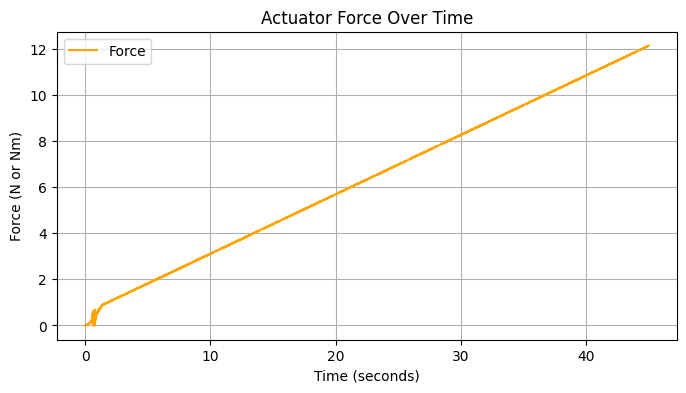

In [48]:
# force_array = np.array(forcevals)  # shape: (timesteps, n_actuator)
fig, ax = plt.subplots(figsize=(8, 4))
# for i in range(model.nu):
#     actuator_name = model.actuator(i).name
#     ax.plot(timevals, force_array[:, i], label=actuator_name)
ax.plot(timevals, forcevals, label='Force', color='orange')
ax.set_title("Actuator Force Over Time")
ax.set_ylabel("Force (N or Nm)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

In [49]:
PROBE_HEIGHT = 0.75  # height of probe above branch in meters
branch_max_disp = pos_array[-1, 0] # branch displacement at the end of the run
branch_max_vel = velvals[-1][0]  # branch velocity at the end of the run
print(f"Final branch displacement: {branch_max_disp:.3f} rad")
# napkin_math_force = (295* branch_max_disp)/PROBE_HEIGHT
napkin_math_force = (295* branch_max_disp + .15*branch_max_vel)/PROBE_HEIGHT
print(f"Napkin math force: {napkin_math_force:.3f} N")
# print(f"Final contact x force: {contact_x_forces[-1]:.3f} N")
print(f"Last applied force: {forcevals[-1]:.3f} N")

os.system('aplay /usr/share/sounds/sound-icons/cembalo-1.wav &')

# print(f"Last probe position: {data.qpos[1]:.6f} m")

Final branch displacement: 0.045 rad
Napkin math force: 17.715 N
Last applied force: 12.126 N


0

Playing WAVE '/usr/share/sounds/sound-icons/cembalo-1.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


      <geom size="0.01 0.01 0.01" pos="0.1 0 0" type="box" rgba="1 0 0 1"/>
      <geom size="0.005 0.0175" pos="0.0975 0 0" quat="0.707107 0.707106 0 0" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 0.0175 0" quat="0.704433 -0.0614407 0.704432 0.0614408" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 -0.0175 0" quat="0.704433 0.0614407 0.704432 -0.0614408" type="cylinder" rgba="1 0 0 1"/>